# **2.7 Tutorial: ChemBERTa: Large-Scale Self-Supervised Pretraining for Molecular Property Prediction using a Smiles Tokenization Strategy**

ChemBERTa : 분자를 위한 언어모델. 1000만개의 SMILES로 학습

Masked Token Inference : 일부르 가려도 앞뒤 문맥으로 정확한 원자 찾아냄

Attention visualization : Transformer의 attention을 시각적으로 보여줌

Finetuing: 1000만개로 학습된 ChemBERTa를 Finetuning가능

In [1]:
!pip install --pre deepchem

In [2]:
import deepchem
import warnings
warnings.filterwarnings('ignore')
deepchem.__version__

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


'2.8.1.dev'

In [3]:
# 1. 필수 라이브러리 설치 (Conda 필요 없음!)
!pip install -q transformers datasets tokenizers
!pip install -q --pre deepchem

# 2. 확인
import deepchem as dc
import transformers
print(dc.__version__)

2.8.1.dev


In [4]:
!pip install -q transformers simpletransformers wandb tokenizers datasets
!pip install -q rdkit

# 2. bertviz (시각화 도구) 설치
!git clone https://github.com/jessevig/bertviz.git

# 3. 보조 레포지토리 (필요한 경우에만)
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.8/330.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.3 MB/s eta 0:00:00
Cloning into 'bertviz'...
remote: Enumerating objects: 1644, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 1644 (delta 230), reused 211 (delta 210), pack-reused 1328 (from 2)
Receiving objects: 100% (1644/1644), 198.37 MiB | 20.00 MiB/s, done.
Resolving deltas: 100% (1078/1078), done.
Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1569, done.
remote: Counting objects: 100% (205/205), do

In [5]:
import os

# 1. 라이브러리 한방 설치
!pip install -q --pre deepchem transformers simpletransformers rdkit wandb

# 2. 경로 설정 및 시각화 도구 준비
if not os.path.exists('bertviz'):
    !git clone https://github.com/jessevig/bertviz.git
import sys
sys.path.append('bertviz')

# 3. 설치 확인
import deepchem as dc
import rdkit
print(f"DeepChem 버전: {dc.__version__}")
print(f"RDKit 버전: {rdkit.__version__}")

DeepChem 버전: 2.8.1.dev
RDKit 버전: 2025.09.4


In [6]:
from transformers import AutoModelForMaskedLM, AutoTokenizer, pipeline, RobertaModel, RobertaTokenizer
from bertviz import head_view

model = AutoModelForMaskedLM.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")
tokenizer = AutoTokenizer.from_pretrained("seyonec/PubChem10M_SMILES_BPE_450k")

fill_mask = pipeline('fill-mask', model=model, tokenizer=tokenizer)

config.json:   0%|          | 0.00/515 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/336M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/108 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/336M [00:00<?, ?B/s]

The tied weights mapping and config for this model specifies to tie roberta.embeddings.word_embeddings.weight to lm_head.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie lm_head.bias to lm_head.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
RobertaForMaskedLM LOAD REPORT from: seyonec/PubChem10M_SMILES_BPE_450k
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.pooler.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Tokenizer : Smiles를 토큰으로 쪼개고 각 토큰에 고유 ID부여

Byte-Pair Encoding : ChemBERTa가 사용하는 방식, 자주 등장하는 글자 조합을 하나의 토큰으로 묶음

In [7]:
smiles_mask = "C1=CC=CC<mask>C1"
smiles = "C1=CC=CC=C1"

masked_smi = fill_mask(smiles_mask)

for smi in masked_smi:
  print(smi)

{'score': 0.9755867719650269, 'token': 33, 'token_str': '=', 'sequence': 'C1=CC=CC=C1'}
{'score': 0.02092379331588745, 'token': 7, 'token_str': '#', 'sequence': 'C1=CC=CC#C1'}
{'score': 0.0007658938993699849, 'token': 21, 'token_str': '1', 'sequence': 'C1=CC=CC1C1'}
{'score': 0.0004129741864744574, 'token': 22, 'token_str': '2', 'sequence': 'C1=CC=CC2C1'}
{'score': 0.00025319057749584317, 'token': 352, 'token_str': '=[', 'sequence': 'C1=CC=CC=[C1'}


Transformer이용 Pre-training 15% Masking하고 학습

벤젠에서 = 올 확률 97.5%확률 예측

In [8]:
import torch
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import rdFMCS
from matplotlib import colors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolToImage
from PIL import Image


def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.Kekulize(mol)
    return mol


def find_matches_one(mol,submol):
    #find all matching atoms for each submol in submol_list in mol.
    match_dict = {}
    mols = [mol,submol] #pairwise search
    res=rdFMCS.FindMCS(mols) #,ringMatchesRingOnly=True)
    mcsp = Chem.MolFromSmarts(res.smartsString)
    matches = mol.GetSubstructMatches(mcsp)
    return matches

#Draw the molecule
def get_image(mol,atomset):
    hcolor = colors.to_rgb('green')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img

Get mol : SMILES를 RDkit 분자 객체로 변화 Kekulize로 단일/이중결합 구분

find_matches_one 두 분자 사이의 최대 공통 부분 구조를 찾아내 모델이 예측한 부분과 기존구조 얼마나 일치하는지 확인

In [10]:
sequence = f"C1=CC=CC={tokenizer.mask_token}1"
substructure = "CC=CC"
image_list = []

# Check if CUDA is available and move model to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

input = tokenizer.encode(sequence, return_tensors="pt")
# Move input tensor to the same device as the model
input = input.to(device)
mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

token_logits = model(input)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
  smi = (sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))
  print (smi)
  smi_mol = get_mol(smi)
  substructure_mol = get_mol(substructure)
  if smi_mol is None: # if the model's token prediction isn't chemically feasible
    continue
  Draw.MolToFile(smi_mol, smi+".png")
  matches = find_matches_one(smi_mol, substructure_mol)
  atomset = list(matches[0])
  img = get_image(smi_mol, atomset)
  img.format="PNG"
  image_list.append(img)

C1=CC=CC=CC1
C1=CC=CC=CCC1
C1=CC=CC=CN1
C1=CC=CC=CCCC1
C1=CC=CC=CCO1


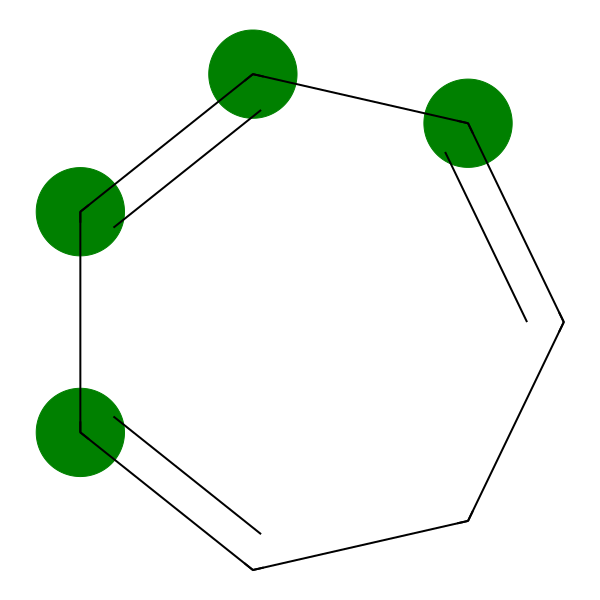

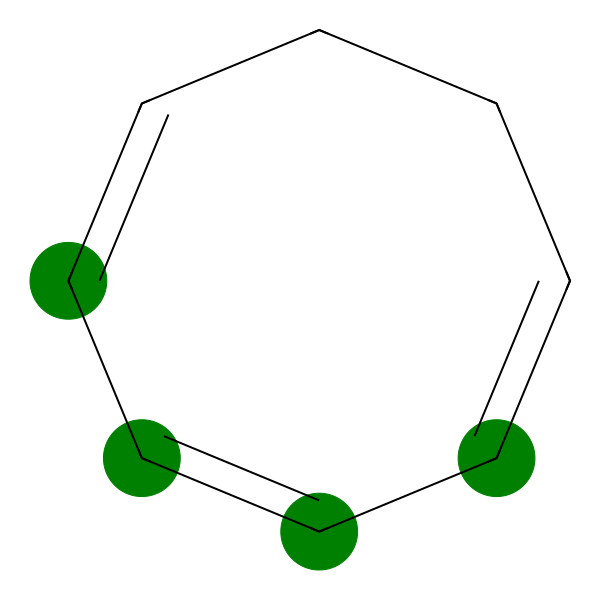

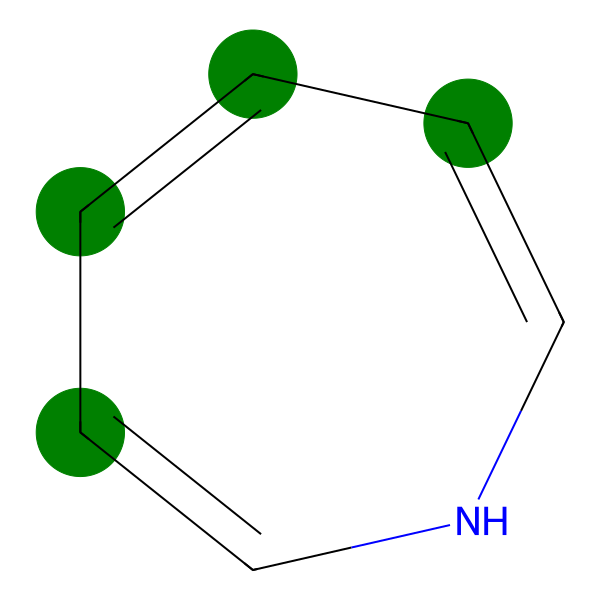

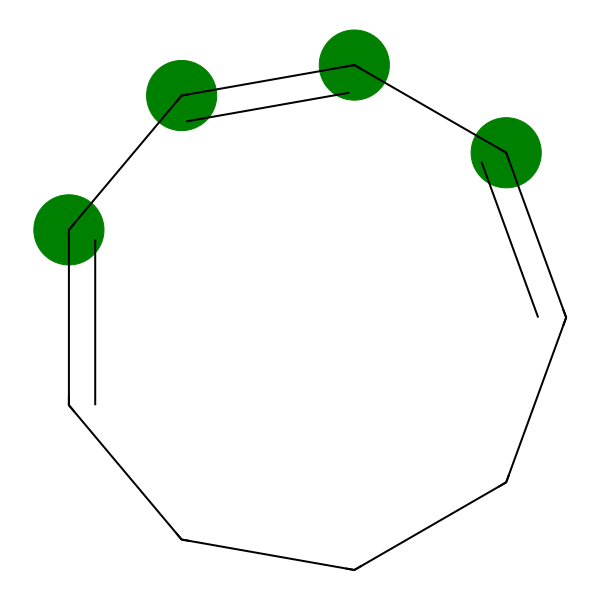

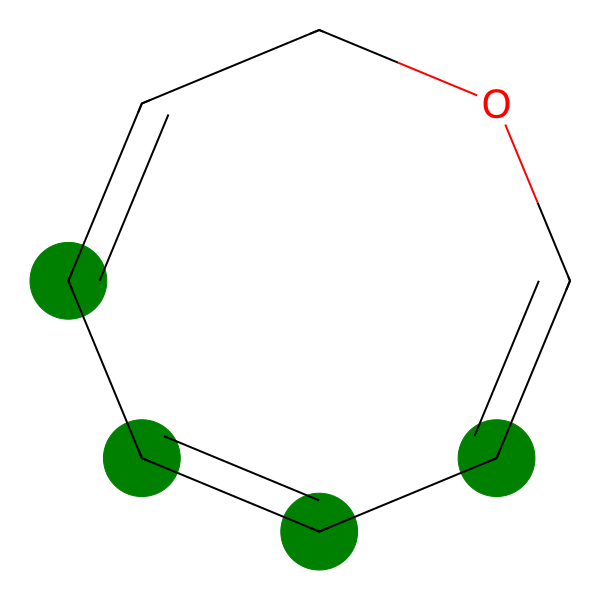

In [11]:
from IPython.display import Image

for img in image_list:
  display(img)

In [12]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [13]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

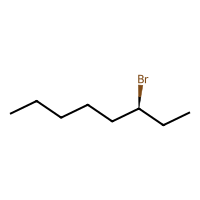

In [16]:
from IPython.display import display
m = Chem.MolFromSmiles('CCCCC[C@@H](Br)CC')
img = Draw.MolToImage(m, size=(200, 200))
display(img)

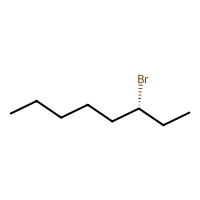

In [20]:
m = Chem.MolFromSmiles('CCCCC[C@H](Br)CC')
img = Draw.MolToImage(m, size=(200,200))
# To display this image, you would typically use:
# from IPython.display import display
display(img)

BertViz를 이용한 Attention 시각화 시계/반시계 @기호하나만 다름

In [22]:
from transformers import RobertaModel, RobertaTokenizer
from bertviz import head_view

model_version = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = RobertaModel.from_pretrained(model_version, output_attentions=True)
tokenizer = RobertaTokenizer.from_pretrained(model_version)

sentence_a = "CCCCC[C@@H](Br)CC"
sentence_b = "CCCCC[C@H](Br)CC"
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
input_ids = inputs['input_ids']
attention = model(input_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

call_html()

head_view(attention, tokens)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: seyonec/PubChem10M_SMILES_BPE_450k
Key                             | Status     |  | 
--------------------------------+------------+--+-
lm_head.dense.bias              | UNEXPECTED |  | 
lm_head.dense.weight            | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 
lm_head.layer_norm.bias         | UNEXPECTED |  | 
lm_head.decoder.bias            | UNEXPECTED |  | 
lm_head.layer_norm.weight       | UNEXPECTED |  | 
lm_head.bias                    | UNEXPECTED |  | 
lm_head.decoder.weight          | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


<IPython.core.display.Javascript object>

Attention by Head View : Head가 어떤 토큰에 집중하는지 보여줌



In [23]:
%cd /content/bert-loves-chemistry

/content/bert-loves-chemistry


In [24]:
!pwd

/content/bert-loves-chemistry


In [25]:
import os

import numpy as np
import pandas as pd

from typing import List

# import molnet loaders from deepchem
from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem


# import MolNet dataloder from bert-loves-chemistry fork
from chemberta.utils.molnet_dataloader import load_molnet_dataset, write_molnet_dataset_for_chemprop

Fine-tuning : ClinTox(독성문제로 FDA 임상 탈락 데이터셋) 1478개로 미세조정

In [26]:
!wget https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt

--2026-02-11 08:25:00--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/vocab.txt
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 16.15.4.211, 16.15.4.250, 16.15.4.168, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|16.15.4.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3524 (3.4K) [text/plain]
Saving to: ‘vocab.txt’

vocab.txt           100%[===================>]   3.44K  --.-KB/s    in 0s      

2026-02-11 08:25:00 (148 MB/s) - ‘vocab.txt’ saved [3524/3524]



In [27]:
tasks, (train_df, valid_df, test_df), transformers = load_molnet_dataset("clintox", tasks_wanted=None)

[08:25:09] Explicit valence for atom # 0 N, 4, is greater than permitted
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[08:25:10] Can't kekulize mol.  Unkekulized atoms: 9
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[08:25:10] Can't kekulize mol.  Unkekulized atoms: 4
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[08:25:10] Can't kekulize mol.  Unk

Using tasks ['CT_TOX'] from available tasks for clintox: ['FDA_APPROVED', 'CT_TOX']


In [28]:
!pip install transformers

In [29]:
train_df

,text,labels
0,CC(C)C[C@H](NC(=O)CNC(=O)c1cc(Cl)ccc1Cl)B(O)O,0
1,O=C(NCC(O)CO)c1c(I)c(C(=O)NCC(O)CO)c(I)c(N(CCO...,1
2,Clc1cc(Cl)c(OCC#CI)cc1Cl,1
3,N#Cc1cc(NC(=O)C(=O)[O-])c(Cl)c(NC(=O)C(=O)[O-])c1,1
4,NS(=O)(=O)c1cc(Cl)c(Cl)c(S(N)(=O)=O)c1,1
...,...,...
1179,CC(C[NH2+]C1CCCCC1)OC(=O)c1ccccc1,1
1180,CC(C(=O)[O-])c1ccc(C(=O)c2cccs2)cc1,1
1181,CC(c1cc2ccccc2s1)N(O)C(N)=O,1
1182,CC(O)C(CO)NC(=O)C1CSSCC(NC(=O)C([NH3+])Cc2cccc...,1


In [30]:
valid_df

,text,labels
0,CC(C)OC(=O)CCC/C=C\C[C@@H]1[C@@H](/C=C/[C@@H](...,1
1,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,1
2,CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)[O-])c(-c...,1
3,CC(C)COCC(CN(Cc1ccccc1)c1ccccc1)[NH+]1CCCC1,1
4,CSCC[C@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)...,1
...,...,...
143,C[C@H](OC(=O)c1ccccc1)C1=CCC23OCC[NH+](C)CC12C...,1
144,C[C@@H](c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,1
145,CC(C)C[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)[C@@H]...,1
146,C[C@H](O)[C@H](O)[C@H]1CNc2[nH]c(N)nc(=O)c2N1,1


In [31]:
test_df

,text,labels
0,C[NH+]1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4C...,1
1,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)C[C@H]2...,1
2,C[NH+]1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,1
3,Nc1nc(NC2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)c2n1,1
4,OC[C@H]1O[C@@H](n2cnc3c2NC=[NH+]C[C@H]3O)C[C@@...,1
...,...,...
143,O=C1O[C@H]([C@@H](O)CO)C([O-])=C1O,1
144,C#CCC(Cc1cnc2nc(N)nc(N)c2n1)c1ccc(C(=O)N[C@@H]...,1
145,C#CC[NH2+][C@@H]1CCc2ccccc21,1
146,[H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...,1


BPE vs SmilesTokenizer : BPE는 범용 후자는 정규표현식을 사용해 화학적으로 의미있게 쪼갬

💡 2.7 ChemBERTa


Transfer Learning: 1,000만 개의 분자 데이터를 사전 학습(Pre-training)한 모델을 활용함으로써, 소량의 데이터만으로 고성능 예측 모델을 구축할 수 있음.

Tokenization: 분자를 단순한 숫자가 아닌 '언어'로 취급하여, BPE나 SmilesTokenizer 같은 기술로 원자 간의 문맥을 파악함.

Attention: Attention 메커니즘을 시각화함으로써 모델이 분자의 어떤 부분(작용기, 결합 등)을 보고 물성을 예측했는지 파악할 수 있음